In [22]:
%matplotlib inline

## Audio processing, Video processing and Computer vision
## Bachelor in Data Science and Engineering - Universidad Carlos III de Madrid

# LAB SESSION 4: IMAGE CLASSIFICATION WITH CNNs

# AUTOMATIC DIAGNOSTIC SYSTEM FOR DIABETIC RETINOPATHY 


### Iván González Díaz


<center><img src='http://www.tsc.uc3m.es/~igonzalez/images/logo_uc3m_foot.jpg' width=400 /></center>

In this practice we are going to build a diabetic retinopahy diagnosis system based on image analysis.

## Part 0: The problem

Before starting the practice, we will briefly describe the database that we will use and the problem we aim to address:

Diabetic Retinopathy (DR) is the leading cause of blindness in the working-age population of the developed world. World Health Organization estimates that 347 million people have the disease worldwide. Diabetic Retinopathy (DR) is an eye disease associated with long-standing diabetes. Around 40% to 45% of Americans with diabetes have some stage of the disease. Progression to vision impairment can be slowed or averted if DR is detected in time, however this can be difficult as the disease often shows few symptoms until it is too late to provide effective treatment.

Our goal is to develop a CNN providing an automatic diagnosis of DR with color fundus photography as input. The need for a comprehensive and automated method of DR screening has long been recognized, and previous efforts have made good progress using image classification, pattern recognition, and machine learning. 

You are provided with a large set of high-resolution retina images taken under a variety of imaging conditions. Left and right fields can be provided indistinctively. Images are labeled with the following data:

- 1.- An image id.
- 2.- An eye indicator (left,right) 
- 3.- A label, indicating the presence of diabetic retinopathy in each image on a scale of 0 to 4, according to the following scale: 0 - No DR, 1 - Mild, 2 - Moderate, 3 - Severe, 4 - Proliferative DR

Figure 1 shows a visual example of a eye color fundus:

![Image of retina](https://www.tsc.uc3m.es/~igonzalez/images/retina.jpg)

The dataset contains 3500 images divided into 3 sets:
- Training set: 2000 images
- Validation set: 500 images
- Test set: 1000 images. 

Additionally, there is a csv file for each dataset (training, validation and test) in which each lines corresponds with a clinical case, defined with two fields separated by commas:
- the numerical id of the lesion: that allows to build the paths to the image.
- 2.- An eye indicator (0-left eye and 1-right eye). It allows mirroring right-eye images so that both left and right eyes are comparable.
- the lesion label: available only for training and validation, being an integer between 0 and 4:  0 - No DR, 1 - Mild, 2 - Moderate, 3 - Severe, 4 - Proliferative DR. In the case of the test set, labels are not available (their value is -1).

For simplicity, we will transform the original labels to produce a binary label: 0 - No DR, 1 - DR. Therefore we tackle a binary classification problem.

Students will be able to use the training and validation sets to build their solutions and finally provide the scores associated with the test set. This practice provides a guideliness to build a baseline reference system. To do so, we will learn two fundamental procedures:

- 1) Process your own database with pytorch
- 2) Design a feedforward CNN that processess images and provides a diagnostic
- 2) Use a regular network that has been pretrained using a large-scale general purpose dataset and fine-tune it for our diagnostic problem

## Part 1: Handling our custom dataset with pytorch
Now we are going to study how we can load and process our custom dataset in pytorch. For that end, we are going to use the package ``scikit-image`` for reading images, and the package ``panda`` for reading csv files.


In [23]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform, util, color
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
from PIL import Image
import pdb
import random
import numpy.random as npr
import cv2

random.seed(42)
npr.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.enabled = False

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


The first thing we need to do is to download and decompress the dataset on a local folder:




In [24]:
#ONLY TO USE GOOGLE COLAB. Run this code only the first time you run this notebook and then comment these lines
#from shutil import copyfile
#from google.colab import drive
#import os, sys
#drive.mount('/content/drive')
#copyfile('/content/drive/My Drive/Colab Notebooks/s4/db1.zip', './db1.zip') #Copy db files to our working folder
#copyfile('/content/drive/My Drive/Colab Notebooks/s4/db2.zip', './db2.zip')


In [25]:
#NOTE: Run this only once, in the machine where you want to run your code, then comment these lines
import zipfile
zipPath='./db1.zip' #path of the 1st zip file
dataFolder='./data' #We extract files to the current folder
with zipfile.ZipFile(zipPath, 'r') as zip_ref:
    zip_ref.extractall(dataFolder)
    
zipPath='./db2.zip' #path of the 2st zip file
dataFolder='./data' #We extract files to the current folder
with zipfile.ZipFile(zipPath, 'r') as zip_ref:
    zip_ref.extractall(dataFolder)
  

Now let's read the indexed file and display data from image 65. The file structure is one row per image of the database, and two fields:
- Image ID (a 5-digit sequence, adding 0 to the left side if required)
- Label: 0 - No DR, 1 - Mild, 2 - Moderate, 3 - Severe, 4 - Proliferative DR
- Eye: 0 left eye, 1 right eye

The images in the dataset come from different models and types of cameras, which can affect the visual appearance of left vs. right. Like any real-world data set, you will encounter noise in both the images and labels. Images may contain artifacts, be out of focus, underexposed, or overexposed. A major aim of this competition is to develop robust algorithms that can function in the presence of noise and variation.



In [26]:
db = pd.read_csv('data/train.csv',header=0,dtype={'id': str, 'eye': int, 'label': int})

#We show inform
n = 65
img_id = db.id[65] 
eye = db.eye[65]
label = db.label[65]



print('Image ID: {}'.format(img_id))
print('Eye: {}'.format(eye))
print('Label: {}'.format(label))


Image ID: 00065
Eye: 0
Label: 3


Now, let's create a simple function to show an image.




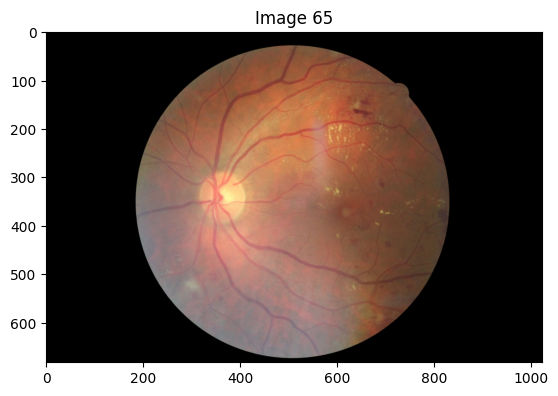

In [27]:
def imshow(image, title_str):
    if len(image.shape)>2:
        plt.imshow(image)
    else:
        plt.imshow(image,cmap=plt.cm.gray)
    plt.title(title_str)        

plt.figure()
imshow(io.imread(os.path.join('data/images/', img_id + '.jpg' )),'Image %d'%n)
plt.show()

### Class Dataset

The class `` torch.utils.data.Dataset`` is an abstract class that represents a dataset.

To create our custom dataset in pytorch we must inherit from this class and overwrite the following methods:

- `` __len__`` so that `` len (dataset) `` returns the size of the dataset.
- `` __getitem__`` to support indexing `` dataset [i] `` when referring to sample $i$

We are going to create the train and test datasets of our diagnostic problem. We will read the csv in the initialization method `` __init__`` but we will leave the explicit reading of the images for the method
`` __getitem__``. This approach is more efficient in memory because all the images are not loaded in memory at first, but are read individually when necessary.

Our dataset, through the method __getitem__, is going to provide samples encoded as a dictionary `` {'image': image, 'eye': eye, 'label': label} ``. Let us note that label is binary, computed from the original levels of the disease:  0-no DR, 1-DR. You can also take an optional `` transform '' argument so that we can add pre-processing and data augmentation techniques.



In [28]:
class RetinopathyDataset(Dataset):
    """Retinopathy dataset."""

    def __init__(self, csv_file, root_dir,transform=None,  maxSize=0):
        """
        Args:
            csv_file (string): Path al fichero csv con las anotaciones.
            root_dir (string): Directorio raíz donde encontraremos la carpeta 'images'
            transform (callable, optional): Transformaciones opcionales a realizar sobre las imágenes.
        """
        self.dataset = pd.read_csv(csv_file,header=0,dtype={'id': str, 'eye': int, 'label': int})
        
        if maxSize>0:
            newDatasetSize=maxSize #maxSize muestras
            idx=np.random.RandomState(seed=42).permutation(range(len(self.dataset)))
            reduced_dataset=self.dataset.iloc[idx[0:newDatasetSize]]
            self.dataset=reduced_dataset.reset_index(drop=True)

        self.root_dir = root_dir
        self.img_dir = os.path.join(root_dir,'images') 
        self.transform = transform
        self.levels = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']
        self.classes = ['No DR', 'DR']
        
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        #Read the imagen
        img_name = os.path.join(self.img_dir,self.dataset.id[idx] + '.jpg')
        image = io.imread(img_name)
        #If the image is from right eye, we mirror it
        if self.dataset.eye[idx]==1:
            image=image[:,::-1,:]
        sample = {'image': image, 'eye' : self.dataset.eye[idx], 'label':  (self.dataset.label[idx]>0).astype(dtype=np.int64)}
        if self.transform:
            sample = self.transform(sample)
        return sample

We now instantiate the class to iterate over some samples to see what we generate.


0 (678, 1024, 3) 0
1 (678, 1024, 3) 0
2 (682, 1024, 3) 1
3 (682, 1024, 3) 0


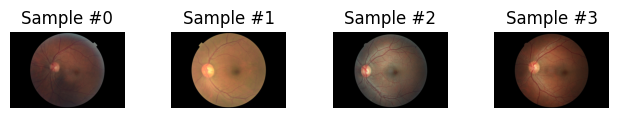

In [29]:
train_dataset = RetinopathyDataset(csv_file='data/train.csv',
                                    root_dir='data')

fig = plt.figure()

for i in range(len(train_dataset)):
    sample = train_dataset[i]
    print(i, sample['image'].shape, sample['label'])

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample['image'])

    if i == 3:
        plt.show()
        break

**IMPORTANT**

The optional parameter ``maxSize`` in the constructor allows us to subsample the number of images and consequently reduce the size of the dataset. If not set included or maxSize=0, then the dataset will include all the images. This parameter is useful to train models over smaller datasets during hyperparameter validation and design phases. Working with less images reduces the training time at the expense of obtaining results that may deviate from those obtained with the full dataset size. Of course, the larger the training dataset, the more stable results but the larger the training time. Hence, it is up to the students the use of this parameter. 

### Data pre-processing and Augmentation: Transforms
----------

In the previously shown examples we can see that the size of the images is not the same. This would prevent to train a convolutional neuronal network, as the vast majority require fixed-size inputs. Furthermore, the image is not always adjusted to the eye, and indeed, in some examples the eyes are small compared to the size of the image, whereas in others they spread along the full image dimensions. It would then be desirable to adjust the input images so that the eye covers almost the entire image.

To do this, we are going to create some preprocessing code, focusing on 5 transformations:
- ``CropByEye``: to crop the eye part of the image and remove surrounding black areas.
- ``Rescale``: to scale the image
- ``RandomCrop``: to crop the image randomly around the image center, it allows us to augment the data samples with random crops
- ``CenterCrop``: to perform a central crop of the image with the indicated size (useful in test)
- ``ToTensor``: to convert numpy matrices into torch tensors (rearranging the axes).

We will define them as callable classes instead of simple functions, as we will not need to pass the transform  parameters every time we call a method. To do this, we only have to implement the `` __call__`` method and, if necessary, the `` __init__`` method.
Then we can use a transformation with the following code:

::

    tsfm = Transform(params)
    transformed_sample = tsfm(sample)


In [30]:
class CropByEye(object):
    """Crop the image using around the eye.

    Args:
        - TH: threshold to segment the eye (values between 0 - black and 1 - white).
        - border (tuple or int): Border surrounding the mask of the eye. We dilate the mask as the contrast between 
        the eye and the background might be important.
        If it is a tuple, then it is (bordery,borderx)
    """

    def __init__(self, threshold, border):
        self.threshold = threshold 
        assert isinstance(border, (int, tuple))
        if isinstance(border, int):
            self.border = (border,border)
        else:
            self.border = border
            
    def __call__(self, sample):
        image, eye, label = sample['image'], sample['eye'],sample['label']
        h, w = image.shape[:2]
        imgray = color.rgb2gray(image)
        #Compute the mask
        th, mask = cv2.threshold(imgray, self.threshold, 1, cv2.THRESH_BINARY)
        #Compute the coordinates of the bounding box that contains the mask 
        sidx=np.nonzero(mask)
        #In case the mask is too small, impies malfunctioning
        if len(sidx[0])<20:
            return {'image': image, 'eye': eye, 'label' : label}
        minx=np.maximum(sidx[1].min()-self.border[1],0)
        maxx=np.minimum(sidx[1].max()+1+self.border[1],w)
        miny=np.maximum(sidx[0].min()-self.border[0],0)
        maxy=np.minimum(sidx[0].max()+1+self.border[1],h)
        #Crop the image
        image=image[miny:maxy,minx:maxx,...]
        

        return {'image': image, 'eye': eye, 'label' : label}
class Rescale(object):
    """Re-scale image to a predefined size.

    Args:
        output_size (tuple or int): The desired size. If it is a tuple, output is the output_size. 
        If it is an int, the smallest dimension will be the output_size
            a we will keep fixed the original aspect ratio.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, eye, label = sample['image'], sample['eye'],sample['label']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        image = transform.resize(image, (new_h, new_w))
        
        return {'image': image, 'eye': eye, 'label' : label}

class RandomCrop(object):
    """Randomly crop the image.

    Args:
        output_size (tuple or int): Crop size. If  int, square crop

    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, eye, label = sample['image'], sample['eye'],sample['label']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        if h>new_h:
            top = np.random.randint(0, h - new_h)
        else:
            top=0
            
        if w>new_w: 
            left = np.random.randint(0, w - new_w)
        else:
            left = 0
            
        image = image[top: top + new_h,
                     left: left + new_w]


        return {'image': image, 'eye': eye, 'label': label}
    
class CenterCrop(object):
    """Crop the central area of the image

    Args:
        output_size (tupla or int): Crop size. If int, square crop

    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, eye, label = sample['image'], sample['eye'],sample['label']
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        rem_h = h - new_h
        rem_w = w - new_w
        
        if h>new_h:
            top = int(rem_h/2)
        else:
            top=0
            
        if w>new_w: 
            left = int(rem_w/2)
        else:
            left = 0
            
        image = image[top: top + new_h,
                     left: left + new_w]

    
        return {'image': image, 'eye': eye, 'label': label}


class ToTensor(object):
    """Convert ndarrays into pytorch tensors."""

    def __call__(self, sample):
        image, eye, label = sample['image'], sample['eye'],sample['label']

        # Cambiamos los ejes
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        image = torch.from_numpy(image)
        label=torch.tensor(label,dtype=torch.long)
        
        return {'image':image,
                'eye':eye,
                'label':label}
    
class Normalize(object):
    """Normalize data by subtracting means and dividing by standard deviations.

    Args:
        mean_vec: Vector with means. 
        std_vec: Vector with standard deviations.
    """

    def __init__(self, mean,std):
      
        assert len(mean)==len(std),'Length of mean and std vectors is not the same'
        self.mean = np.array(mean)
        self.std = np.array(std)

    def __call__(self, sample):
        image, eye, label = sample['image'], sample['eye'],sample['label']
        c, h, w = image.shape
        assert c==len(self.mean), 'Length of mean and image is not the same' 
        dtype = image.dtype
        mean = torch.as_tensor(self.mean, dtype=dtype, device=image.device)
        std = torch.as_tensor(self.std, dtype=dtype, device=image.device)
        image.sub_(mean[:, None, None]).div_(std[:, None, None])
    
        
        return {'image': image, 'eye': eye, 'label' : label}

### Exercise:

Use the following code to apply the previous transforms and experiment with the values of the parameters to study their influence. Read the documentation at the begining of each class to understand the sintaxis of the input parameters.



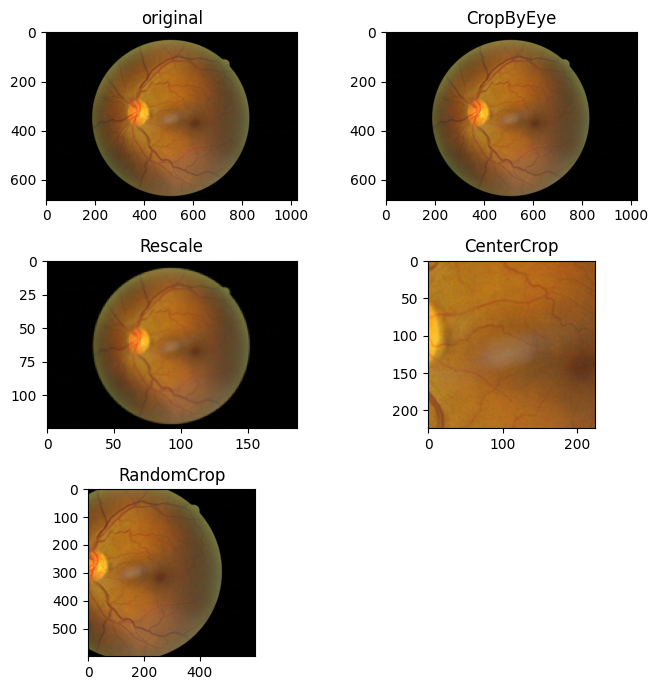

In [31]:
### Modify this code to make your experiments....
cropByEye = CropByEye(threshold=0.99,border=0)
scale = Rescale(125)
rcrop = RandomCrop(600)
ccrop = CenterCrop(224)

# Apply each of the above transforms on sample.
fig = plt.figure(figsize=(7,7))
sample = train_dataset[4]
ax = plt.subplot(3,2, 1)
plt.tight_layout()
ax.set_title('original')
plt.imshow(sample['image'])
    
for i, tsfrm in enumerate([cropByEye,scale, ccrop, rcrop]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(3, 2, i+2)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    plt.imshow(transformed_sample['image'])

plt.show()

#### Using package torchvision.transforms

Package torchvision.trasforms comes with many useful methods that implement valuable transforms for data augmentation. Those transforms can be applied either to torch.tensors or to images. However, torchvision uses PIL library to read and process images, in contrast to the matrix representation of images used in scikit-image library (the library we have used in the previous methods). Hence, in order to use a torchvision transform we need to implement a pipeline that:

- 1) First, convert the matrix-based images to PILImages
- 2) Apply the transform to PILImages
- 3) Convert PILImages to matrices

And applies these to input images. The following class ``TVCenterCrop`` implements the same functionality as the previous ``CenterCrop``, but using the corresponding method in torchvision. It is therefore a useful example if you plan to make use of torchvision transforms.


In [32]:
class TVCenterCrop(object):
    """Crop the central area of the image. Example using the method in torchvision. Requires to
    internally convert from skimage (numpy array) to PIL Image

    Args:
        output_size (tupla or int): Crop size. If int, square crop

    """

    def __init__(self, size):
        self.CC=transforms.CenterCrop(size)

    def __call__(self, sample):
        image, eye, label = sample['image'], sample['eye'],sample['label']
        pil_image=Image.fromarray(util.img_as_ubyte(image))
        pil_image=self.CC(pil_image)
        image=util.img_as_float(np.asarray(pil_image))
        
        return {'image': image, 'eye': eye, 'label': label}

Now, we apply to transform to check the results

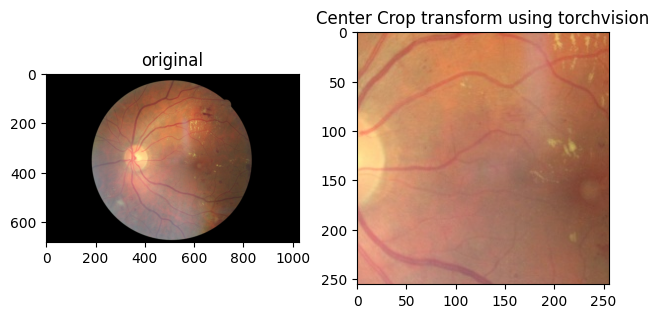

In [33]:
# Apply each of the above transforms on sample.
fig = plt.figure()
sample = train_dataset[65]
ax = plt.subplot(1,2, 1)
plt.tight_layout()
ax.set_title('original')
plt.imshow(sample['image'])

tvcc=TVCenterCrop(256)

transformed_sample = tvcc(sample)
ax = plt.subplot(1, 2, 2)
plt.tight_layout()
ax.set_title('Center Crop transform using torchvision')
plt.imshow(transformed_sample['image'])

plt.show()

### Exercise

Implement other transforms using torchvision package. Take TVCenterCrop as guide.


In [34]:
### Put your code here....
class ColorJitter(object):
    """Randomly change the brightness, contrast, saturation and hue of an image.

    Args:
        brightness (float or tuple) =  How much to jitter brightness.
        contrast (float or tuple) = How much to jitter contrast
        saturation (float or tuple) = How much to jitter saturation
        hue (float or tuple) = How much to jitter hue

    """

    def __init__(self, brightness, contrast, saturation, hue):
        self.CJ = transforms.ColorJitter(brightness, contrast, saturation, hue)

    def __call__(self, sample):
        image, eye, label = sample['image'], sample['eye'],sample['label']
        pil_image=Image.fromarray(util.img_as_ubyte(image))
        pil_image=self.CJ(pil_image)
        image=util.img_as_float(np.asarray(pil_image))
        
        return {'image': image, 'eye': eye, 'label': label}

class RandomHorizontalFlip(object):

    def __init__(self, p = None):
        self.RHF=transforms.RandomHorizontalFlip(p)

    def __call__(self, sample):
        image, eye, label = sample['image'], sample['eye'],sample['label']
        pil_image=Image.fromarray(util.img_as_ubyte(image))
        pil_image=self.RHF(pil_image)
        image=util.img_as_float(np.asarray(pil_image))
    
        
        return {'image': image, 'eye': eye, 'label': label}

class RandomVerticalFlip(object):

    def __init__(self, p = None):
        self.RVF=transforms.RandomVerticalFlip(p)

    def __call__(self, sample):
        image, eye, label = sample['image'], sample['eye'],sample['label']
        pil_image=Image.fromarray(util.img_as_ubyte(image))
        pil_image=self.RVF(pil_image)
        image=util.img_as_float(np.asarray(pil_image))
        
        
        return {'image': image, 'eye': eye, 'label': label}

class TVRandomGrayscale(object):
    def __init__(self, p=0.1):
        self.grayscale = transforms.RandomGrayscale(p=p)
        
    def __call__(self, sample):
        image, eye, label = sample['image'], sample['eye'],sample['label']
        pil_image=Image.fromarray(util.img_as_ubyte(image))
        pil_image = self.grayscale([pil_image])
        image=util.img_as_float(np.asarray(pil_image))
        
        
        return {'image': image, 'eye': eye, 'label': label}


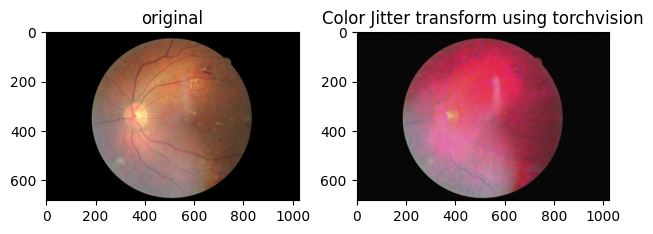

In [35]:
# Apply each of the above transforms on sample.
fig = plt.figure()
sample = train_dataset[65]
ax = plt.subplot(1,2, 1)
plt.tight_layout()
ax.set_title('original')
plt.imshow(sample['image'])

tvcj=ColorJitter(0.2,1.2,1.5,0.2)

transformed_sample = tvcj(sample)
ax = plt.subplot(1, 2, 2)
plt.tight_layout()
ax.set_title('Color Jitter transform using torchvision')
plt.imshow(transformed_sample['image'])

plt.show()

### Composed Transforms

Now let's apply the different transformations to our images. 

We will rescale the images so that their smallest dimension is 224 and then make random crops of size 224. To compose the transformations ``Rescale`` and ``RandomCrop`` we can use ``torchvision.transforms.Compose``, which is a simple callable class.


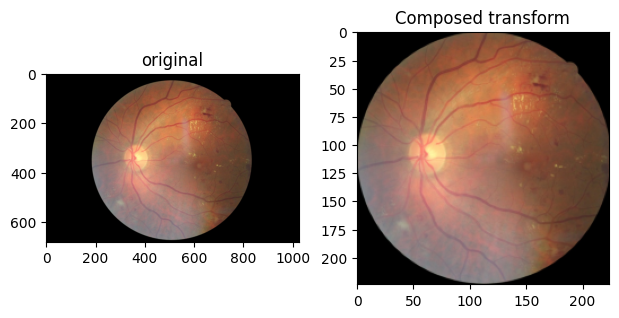

In [36]:
composed = transforms.Compose([CropByEye(0.10,1),Rescale(224),RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = train_dataset[65]
ax = plt.subplot(1,2, 1)
plt.tight_layout()
ax.set_title('original')
plt.imshow(sample['image'])
    
transformed_sample = composed(sample)
ax = plt.subplot(1, 2, 2)
plt.tight_layout()
ax.set_title('Composed transform')
plt.imshow(transformed_sample['image'])

plt.show()

### Exercise:

Use the previous code to test different combinations of transform and discuss the results.

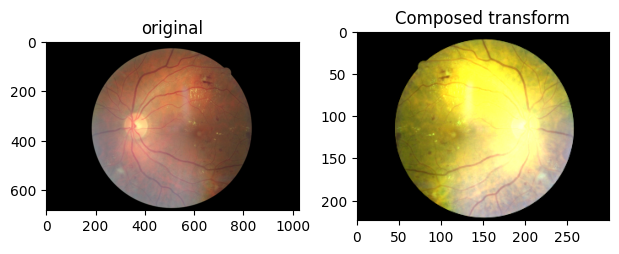

In [37]:
composed = transforms.Compose([CropByEye(15, border=1), 
                               Rescale(224), 
                               CenterCrop(300), 
                               RandomHorizontalFlip(1),
                               ColorJitter(0.2, 0.9, 0.6, 0.2)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = train_dataset[65]
ax = plt.subplot(1,2, 1)
plt.tight_layout()
ax.set_title('original')
plt.imshow(sample['image'])
    
transformed_sample = composed(sample)
ax = plt.subplot(1, 2, 2)
plt.tight_layout()
ax.set_title('Composed transform')
plt.imshow(transformed_sample['image'])

plt.show()

### Exercise:

Data augmentation techniques are useful as long as they model random transforms that may happen in the real world, and so can be found in test. Hence, the choice of the data augmentation techniques to be applied is problem-dependent and may differ from one dataset to another. Have a look at the images in the dataset and try to figure out which transforms are appropriate for these problem. Imagine how colorfundus images are taken and which factors may differ from one capture to another. Your results in the challenge will strongly depend on your design!!!!

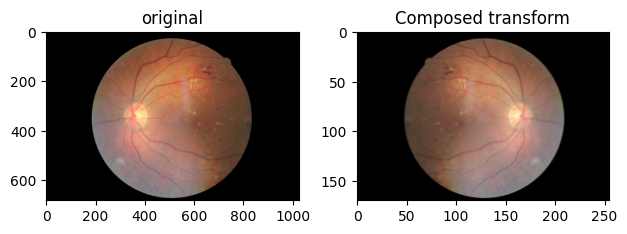

In [38]:
### Put your code here....
composed = transforms.Compose([CropByEye(15, border=1), 
                               Rescale(170), 
                               CenterCrop(300), 
                               RandomHorizontalFlip(1),
                               ColorJitter(0.1, 0, 0.5, 0)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = train_dataset[65]
ax = plt.subplot(1,2, 1)
plt.tight_layout()
ax.set_title('original')
plt.imshow(sample['image'])
    
transformed_sample = composed(sample)
ax = plt.subplot(1, 2, 2)
plt.tight_layout()
ax.set_title('Composed transform')
plt.imshow(transformed_sample['image'])

plt.show()





Iterating the dataset
-----------------------------

We can now put everything together to create the train and test datasets with the corresponding transformations.
In summary, every time we sample an image from the dataset (during training):
- We will read the image
- We will apply the transformations and we will crop the image using a bounding box indicating the eye area, which is automatically computed from the input image by thresholding.
- As the final cropping operation is random, we perform data augmentation during sampling

We can easily iterate over the dataset with a ``for i in range`` loop.


In [39]:
#Pixel means and stds expected by models in torchvision
pixel_mean=[0.485, 0.456, 0.406]
pixel_std=[0.229, 0.224, 0.225]

#Train Dataset
train_dataset = RetinopathyDataset(csv_file='data/train.csv',
                                    root_dir='data',
                                    maxSize=500, ###IMPORTANT: maxSize=500 to speed-up the training process
                                                 ### Set to 0 or 2000 for training your optimal model
                                    transform=transforms.Compose([
                                    CropByEye(0.10,1),
                                    Rescale(224),
                                    RandomCrop(224),
                                    ToTensor(),
                                    Normalize(mean=pixel_mean,
                                    std=pixel_std)
                                    ]))
#Val dataset
val_dataset = RetinopathyDataset(csv_file='data/val.csv',
                                    root_dir='data',
                                    transform=transforms.Compose([
                                    CropByEye(0.10,1),
                                    Rescale(224),
                                    CenterCrop(224),
                                    ToTensor(),
                                    Normalize(mean=pixel_mean,
                                    std=pixel_std)
                                    ]))

#Test dataset
test_dataset = RetinopathyDataset(csv_file='data/test.csv',
                                    root_dir='data',
                                    transform=transforms.Compose([
                                    CropByEye(0.10,1),
                                    Rescale(224),
                                    CenterCrop(224),
                                    ToTensor(),
                                    Normalize(mean=pixel_mean,
                                    std=pixel_std)
                                    ]))

for i in range(len(train_dataset)):
    sample = train_dataset[i]

    print(i, sample['image'].size(), sample['label'])

    if i == 3:
        break

0 torch.Size([3, 224, 224]) tensor(1)
1 torch.Size([3, 224, 224]) tensor(0)
2 torch.Size([3, 224, 224]) tensor(0)
3 torch.Size([3, 224, 224]) tensor(0)


Finally, we have to create a dataloader allowing to:

- Sample batches of samples to feed the network during training
- Shuffle data
- Load the data in parallel using multiple cores.

``torch.utils.data.DataLoader`` is an iterator that provides all these features. An important parameter of the iterator is ``collate_fn``. We can specify how samples are organized in batches by choosing the most appropriate function. In any case, the default option should work fine in most cases.




0 torch.Size([256, 3, 224, 224]) tensor([1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1,
        0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
        1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
        1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
        1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
        1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1])


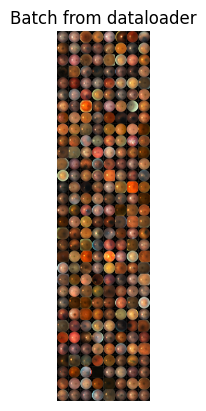

1 torch.Size([244, 3, 224, 224]) tensor([0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0,
        0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
        1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1,
        0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 1])


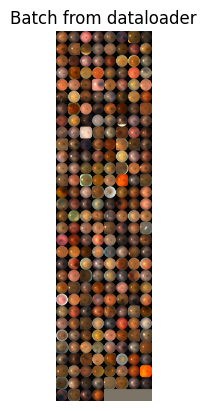

In [45]:
#Specify training dataset, with a batch size of 8, shuffle the samples, and parallelize with 3 workers
#IMPORTANT!!!!! If you plan to run this in a Windows machine, set num_workers=0. Pytorch has a bug on windows
train_dataloader = DataLoader(train_dataset, batch_size=256,
                        shuffle=True, num_workers=0, pin_memory=True)
#Validation dataset => No shuffle
val_dataloader = DataLoader(val_dataset, batch_size=256,
                        shuffle=False, num_workers=0, pin_memory=True)

#Test Dataset => => No shuffle
test_dataloader = DataLoader(test_dataset, batch_size=256,
                        shuffle=False, num_workers=0, pin_memory=True)


# Auxiliary function to visualize a batch
def show_batch(sample_batched):
    """Mostramos las lesiones de un batch."""
    images_batch, labels_batch = \
            sample_batched['image'], sample_batched['label']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2
    
    #Generamos el grid
    grid = utils.make_grid(images_batch)
    #Lo pasamos a numpy y lo desnormalizamos
    grid=grid.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    grid = std * grid + mean
    grid = np.clip(grid, 0, 1)
    plt.imshow(grid)
    plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(train_dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['label'])
    plt.figure()
    show_batch(sample_batched)
    plt.axis('off')
    plt.ioff()
    plt.show()
        
    #We show the data of the 3rd batch and stop.
    if i_batch == 3:
        break

## Part 2: Design and train a custom diagnosis network
In the second part of the practice we are designing a diagnosis network from scratch. For that end, we next provide a definition of a network which is very similar to LeNet-5, which aims to classifiy input images of size 32x32 px containing digits (MNIST dataset with 10 classes). However, in this case, we are not forced to work with such small images and, indeed, it is highly recommended to user larger sizes (e.g. 224x224 px as it represents the standard size for most well-known networks trained in Imagenet). 

In the following cell we provide the skeleton of a network called CustomNet, with the necessary methods: ` __init__` (constructor) and ``forward`` (forward method processes an image and provides a vector with the scores of the 2 classes considered in our problem).


In [47]:
#Example network
class CustomNet(nn.Module):
    def __init__(self):
        # In the constructor we will specify those processing blocks which require learnable parameters
        # We just define them to ensure persistence during training, although they will remain disconnected
        # until we define a processing pipeline in forward method.
        super(CustomNet, self).__init__()

        #2D convolution to operate over RGB images
        self.conv1 = nn.Conv2d(3, 8, 5)
        # Maxpooling with kernel 2x2 and stride=2
        self.pool = nn.MaxPool2d(2, 2)
        # 2D convolution
        self.conv2 = nn.Conv2d(8, 16, 3)
        # 2D convolution
        self.conv3 = nn.Conv2d(16, 32, 3)
        # 2D convolution
        self.conv4 = nn.Conv2d(32, 64, 3)
        # Fully-connected layer which expects a linearized vector input (after flattening)
        # and produces 120 channels at the output
        self.fc1 = nn.Linear(21632, 1000)
        # Fully-connected layer 
        self.fc2 = nn.Linear(1000, 128)
        # Fully-connected layer 
        self.fc3 = nn.Linear(128, 32)
        # Fully-connected layer 
        self.fc4 = nn.Linear(32, 2)

    #In forward method we connect layers and define the processing pipeline of the network
    def forward(self, x):
        #Convolutional Blocks => Conv -> Relu -> pool
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # x = self.pool(F.relu(self.conv4(x)))
        #Flatten method vectorizes the spatial output of size hxwxchannels into a vector of length h*w*channels
        #by setting the parameter to 1, we start to flatten in dim=1 and do not vectorize the dimension representing
        #the images in the batch
        x = x.flatten(1)
        
        #Fully connected blocks => Linear -> Relu
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        return x

#### Exercise:

Modify the previous code and define a CNN that processes a batch of images (e.g. of size 224x224) and computes their outputs with the scores for the 2 classes that we consider in our problem (non DR, DR). 

**IMPORTANT**: The structure of the network must be consistent in order to transform the input tensor  Nx3x224x224 (N the number of images in the batch, 3 the RGB channels, and 224 the spatial dimensions) into the tensor with the scores of each case, with size Nx2 (N the number of images in the batch and 2 the 2 classes of the problem). To do so, you have to adjust the architecture of the previous example, including the number of layers, the strides of each one, etc. so that it transforms the input tensor into the desired final vector. As an aid, the following code is provided that allows you to run the grid over a batch of images and see what the is shape of the output.

In [48]:
customNet = CustomNet() #we initialize the network
customNet.to(device) #copy the network to the device (gpu)
#Sample a batch of data and get images and labels 
data=next(iter(train_dataloader))
inputs = data['image'].to(device).float()
labels = data['label'].to(device)

batchSize = labels.shape
print('Size of tensor containing a batch of images is {}'.format(inputs.shape))

#Lo pasamos por la red
with torch.set_grad_enabled(False):
    outputs = customNet(inputs)
    print('Size of the output tensor is {}'.format(outputs.shape))

Size of tensor containing a batch of images is torch.Size([256, 3, 224, 224])
Size of the output tensor is torch.Size([256, 2])


**Hint**: Start commenting all lines in the forward method in except of the first convolutional layer, execute the previous cell and and you will see the shape of the output of that layer. Go uncommenting layer by layer to see the sequential output sizes to decide how many convolutional layers may be adequate and the dimensions of the first fully convolutional layer. 

## Part 3: Train and evaluate our CNN

In the third part of the practice we are going to build a first automatic system for the diagnosis of Diabetic Retinopathy based on the network that we have created in the previous section. To train and evaluate the network, we need to define several elements, such as the performance metric, the loss function, the optimizer or the learning rate strategy. In the next sections we will configure these elements.

### Performance Metric for evaluation
We will start by defining the metric we will use to evaluate our network. In particular, we will use the area under the ROC or AUC (https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve).

AUC is a metric that avoids setting a specific threshold to make detections and is applied over the soft outputs of a **binary** classifier. By modifying the value of the threshold, we can build a ROC curve setting the False Positive Rate (FPR) in the y-axis and the True Positive Rate (TPR) in the x-axis. TPR is the proportion of positive cases than have been succesfully detected, whereas FPR is the number of false detections divided by the number of negatives. 

For low detection thresholds and an imperfect system, TPR will be high at the expense of a high FPR (as the system always says 1). For high threholds, the opposite situation happens. Once the ROC is built, the AUC measures the integral behind the curve, which is in the range [0,1]. 

Although, at least theoretically, AUC can be lower than 0.5, in pratice, the output of a baseline system that randomly decides 0 or 1 with equal probability obtains an AUC=0.5, so lower values are usually caused by bugs in the code (and could be avoided just by inverting the outputs of the system).

The following figure shows some examples of AUC and ROC curves:

<center><img src='https://upload.wikimedia.org/wikipedia/commons/thumb/1/13/Roc_curve.svg/1024px-Roc_curve.svg.png' width=384 /></center>

As we have mentioned, AUC is a metric to evaluate binary problems (labels 0,1), and has the advantage of being independent of the detection threshold. It also behaves well against unbalanced problems, as it evaluates the ranking of the scores (their order with respect to the labels) and not their absolute values.

Since our problem is binary (DR vs no DR), we will use AUC to assess the performance, with the following method from scikit-learn:

> auc = metrics.roc_auc_score(labels, scores)


### Loss function, optimizer, and learning rate strategy 

In the next cell we will define the 3 elements we need to train:
- The loss function, which will be a crossed entropy. Using the loss BCEWithLogitsLoss(), we implement a sigmoid to obtain the p(y=1|x) followed by a Binary Cross-Entropy (BCE) loss. 
- The optimizer, in which we will use a SGD with momentum, with certain values of lr and momentum
- A learning rate strategy, using a fixed step method, decreasing the lr by a factor of 10, every 7 epochs.


In [50]:
#Repeat network definition
customNet = CustomNet()
customNet.to(device) #copy the network to the device (gpu)
#Loss function
criterion = nn.CrossEntropyLoss()

# SGD with momentum 
optimizer_ft = optim.Adam(customNet.parameters(), lr=1e-5)

# An lr strategy which decreases lr by a factor of 0.1 every 10 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

### Training function

We continue by defining the function that we will use to train our classifier. Note the existence of 3 nested loops:
- Epoch loop: a main loop that goes through training epochs and then allows values to be taken from the evaluation metrics.
- Database loop: the train database is executed first, training the model, and then the validation database, only to obtain outputs and calculate evaluation metrics.
- Loop of iterations: in each iteration the forward, the evaluation of the loss, the backward and the updating of the weights in the optimizer are made.

In [51]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_auc = 0
    best_epoch = -1
    
    # Initialize lists to store loss and AUC for each epoch
    train_losses = []
    val_losses = []
    train_aucs = []
    val_aucs = []
    
    # Loop over epochs
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set the model to training mode
            else:
                model.eval()   # Set the model to evaluation mode (no grads)
    
            # Dataset size
            numSamples = dataset_sizes[phase]
            
            # Create variables to store outputs and labels
            outputs_m = np.zeros((numSamples, 1), dtype=float)
            labels_m = np.zeros((numSamples,), dtype=int)
            running_loss = 0.0
            
            contSamples = 0
            
            # Iterate over data (loop over batches)
            for sample in dataloaders[phase]:
                inputs = sample['image'].to(device).float()
                labels = sample['label'].to(device)
                
                # Batch Size
                batchSize = labels.shape[0]
                
                # Zero the parameter gradients
                optimizer.zero_grad()
    
                # Forward pass
                # Track history only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
    
                    # Backward pass and optimize only in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Accumulate the running loss
                running_loss += loss.item() * inputs.size(0)
                
                # Apply softmax to the outputs
                outputs = F.softmax(outputs.data, dim=1)
                
                # Store outputs and labels
                outputs_m[contSamples:contSamples+batchSize] = outputs[:, -1:].cpu().numpy()
                labels_m[contSamples:contSamples+batchSize] = labels.cpu().numpy()
                contSamples += batchSize
                
            # At the end of an epoch, update the learning rate scheduler
            if phase == 'train':
                scheduler.step()
            
            # Calculate loss and AUC for the epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_auc = metrics.roc_auc_score(labels_m, outputs_m)
                             
            print('{} Loss: {:.4f} AUC: {:.4f}'.format(phase, epoch_loss, epoch_auc))
    
            # Deep copy the best model
            if phase == 'val' and epoch_auc > best_auc:
                best_auc = epoch_auc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_epoch = epoch
                
            # Store the loss and AUC for plotting
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_aucs.append(epoch_auc)
            else:
                val_losses.append(epoch_loss)
                val_aucs.append(epoch_auc)
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best model in epoch {:d} val AUC: {:.4f}'.format(best_epoch, best_auc))
    
    # Plot training and validation loss over epochs
    plt.figure(figsize=(10, 5))
    plt.title("Training and Validation Loss")
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Plot training and validation AUC over epochs
    plt.figure(figsize=(10, 5))
    plt.title("Training and Validation AUC")
    plt.plot(train_aucs, label="Train AUC")
    plt.plot(val_aucs, label="Validation AUC")
    plt.xlabel("Epoch")
    plt.ylabel("AUC")
    plt.legend()
    plt.show()
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Specifying the data loaders
Now we are going to assign the dataloaders that we had previously to the arrays of train and val

In [52]:
image_datasets = {'train' : train_dataset, 'val': val_dataset}

dataloaders = {'train' : train_dataloader, 'val': val_dataloader}
          
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}
class_names = image_datasets['train'].classes


### Train your custom network
Finally, we can train the network for several epochs and see the train and validation results.

In [ ]:
#We fix seeds for reproducibility
random.seed(42)
npr.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

# Configurar la reproducibilidad de operaciones determinísticas si usas CUDA
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
    

customNet = train_model(customNet, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=10)

Epoch 0/9
----------


#### Exercise:

The current code trains the network for 10 epochs using SGD with momentum, with a learning rate strategy and an early stop strategy (taking the epoch that obtains the best results in validation). You can modify this setting by choosing other values for parameters, optimizers, strategies, etc.


#### Exercise

The current code trains the network for 10 epochs and then returns the model that obtains the best results in validation (measured through the AUC). It could be necessary, in case the training times are long and you work with Google Colab (with limits on the duration of the session), to implement a save-and-resume strategy that allows you to train models through different sessions . You can find details on how to do it at:

https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_a_general_checkpoint.html

## Part 4: Fine-tuning a pre-trained model

Now, instead of training a CNN designed by us from the beginning, we are going to do a fine-tuning of a network that has previously been trained for another task. As seen in theory, this is usually a good alternative when there is not a large amount of data to train (in proportion to the parameters to be learned).

In particular, we are going to use the Alexnet CNN network, included in the ``torchvision`` package, with the weights that have been pre-trained in Imagenet.

The difference between both cases is that ImageNet has 1000 categories of objects and our database has 2 (non-DR, DR). Therefore, we will be able to reuse the entire network except the last layer, where the dimensions will be different from our problem. Therefore, once we load the model, we will overwrite the last layer with a new one, with randomly initialized weights, that meets the dimensions of our database.


In [26]:
# Load the model => With pretrained=True we load the optimal weights for ImageNet, 
# a dataset that has 1000 object categories => We do fine-tuning for our binary classification problem
ftNet = models.alexnet(pretrained=True)
#Print model structure
print(ftNet)
#Get the number of features of the last hidden layer
num_ftrs = ftNet.classifier[6].in_features
# Adjust the last layer to produce two scores
num_classes = 2
# Generate a new layer that substitutes the old one
ftNet.classifier[6] = nn.Linear(num_ftrs,num_classes)
# Show again the structure of the model with the modifications
print(ftNet)
ftNet = ftNet.to(device)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### Re-define the optimizer for the new network
The previous one was used on the customNet parameters, so we have to define a new one on the new network.

In [27]:
# SGD with momentum 
optimizer_ft = optim.SGD(ftNet.parameters(), lr=1e-3, momentum=0.9)

# An lr strategy which decreases lr by a factor of 0.1 every 10 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

### Train

In [28]:
#We fix seeds for reproducibility
random.seed(42)
npr.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

# Configurar la reproducibilidad de operaciones determinísticas si usas CUDA
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

ftNet = train_model(ftNet, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 0.8216 AUC: 0.5230
val Loss: 0.7247 AUC: 0.5487

Epoch 1/9
----------
train Loss: 0.6360 AUC: 0.5662
val Loss: 0.5514 AUC: 0.6293

Epoch 2/9
----------
train Loss: 0.5906 AUC: 0.5926
val Loss: 0.5397 AUC: 0.6400

Epoch 3/9
----------
train Loss: 0.5507 AUC: 0.6833
val Loss: 0.5616 AUC: 0.6349

Epoch 4/9
----------
train Loss: 0.5363 AUC: 0.7073
val Loss: 0.5539 AUC: 0.6371

Epoch 5/9
----------
train Loss: 0.5169 AUC: 0.7367
val Loss: 0.5427 AUC: 0.6427

Epoch 6/9
----------
train Loss: 0.5022 AUC: 0.7621
val Loss: 0.5494 AUC: 0.6470

Epoch 7/9
----------
train Loss: 0.5073 AUC: 0.7423
val Loss: 0.5449 AUC: 0.6418

Epoch 8/9
----------
train Loss: 0.4878 AUC: 0.7727
val Loss: 0.5398 AUC: 0.6533

Epoch 9/9
----------
train Loss: 0.4831 AUC: 0.7787
val Loss: 0.5898 AUC: 0.6467

Training complete in 14m 5s
Best model in epoch 8 val AUC: 0.653276


#### Exercise

The current solution uses Alexnet pre-trained on ImageNet and then fine-tunes it for our particular problem. You can try other networks, many of which come pre-trained in the ``torchvision`` package. For this, it is always necessary to adapt the last layers to our database, generating 2-position outputs. You can find a guide at:

https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

In addition to the torchvision models, github and other repositories also have very competitive networks that could be useful.



## Part 5: Evaluation (Important)
The evaluation of this practice will be done through a challenge, for which the students will have to send the results based on the test data in two categories:

- 1) CUSTOM Category: The results on the test set of a custom network, created from scratch by the students. In this case, the complete code of the network must appear in cells of the notebook and it will not be possible to make use of external networks/packages or pre-trained models.

- 2) FINE-TUNING Category: The results on the test set of a network that has been previously initialized in another database (with fine-tuning). In this case, existing models in torchvision or even external networks can be used.

In addition, the final mark will depend both on the results in both categories and on the content of a brief report (1 side for the description, 1 side for extra material: tables, figures and references) where they will describe the most important aspects of the proposed solutions. The objective of this report is for the teacher to assess the developments/extensions/decisions made by the students when optimizing their system. You do not need to provide an absolute level of detail about the changes made, just list them and briefly discuss the purpose of the changes.

### Details of the material to send for evaluation:

One zip file will be uploaded per group with the following contents:

- Two .csv files with the test outputs of the models that have trained in the two categories. Each file will contain a matrix of size 1000x1, with the DR score for each of the 1000 images in the test dataset. The array should be provided in text format (with 1 number per row). Code to generate the outputs is provided later.

- The report as described above.

- The notebook that integrates the creation of both models so that the teacher can check how things have been implemented.

The deadline for submission of your results + the report is Sunday Nov 03 at 23:59.


Next we provide some functions that allow to test the network and create the csv file with the outputs.


In [137]:
### Code that generates the test matrix
def test_model(model):
    since = time.time()
    
    
    model.eval()   # Ponemos el modelo en modo evaluación

    #Tamaño del dataset
    numSamples = len(test_dataset)
            
    # Creamos las variables que almacenarán las salidas y las etiquetas
    outputs_m=np.zeros((numSamples,1),dtype=float)
    labels_m=np.zeros((numSamples,),dtype=int)
    contSamples=0
            
    # Iteramos sobre los datos
    for sample in test_dataloader:
        inputs = sample['image'].to(device).float()
                
                
        #Tamaño del batch
        batchSize = inputs.shape[0]
                
        # Paso forward
        with torch.torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
                
            #Aplicamos un softmax a la salida
            outputs=F.softmax(outputs.data,dim=1)
            outputs_m [contSamples:contSamples+batchSize,:]=outputs[:,-1:].cpu().numpy()
            contSamples+=batchSize
                
            
    return outputs_m

Running the previous function and obtaining the matrix with the scores of the class 1 (Nx1)

In [ ]:
outputs=test_model(ftNet)

And finally save the matrix into a csv file

In [ ]:
outputs.shape

In [ ]:
import csv

with open('output_test.csv', mode='w') as out_file:
    csv_writer = csv.writer(out_file, delimiter=',')
    csv_writer.writerows(outputs);

In [ ]:
print(outputs)